# Regression example 


The goal of this script is to illustrate parametric and nonparametric regression
for estimating a noisily observed time series of observations (from e.g. a total station).

For this, do the following:

    1. Definitions and imports
    2. Simulate the data
    3. Parametric regression 
    4. Nonparametric regression: Kernel smoothing
    5. Plots and illustrations

The following entries may be changed to explore the script:

    * sigma_noise , sigma_signal  : Both together define the signal-to-noise ration in the data
    * corr_length_signal          : A quantity describing how slow the correlation between values drops 
                                   depending on temporal separation. Increase to generate a smoother signal.
    * corr_length_signal_guess    : A guess for the smoothness of the signal that is to be extracted from the 
                                   measured data. Increase for smoother guess.
    * sigma_noise_guess           : A guess for the average magnitude of the noise. 
                                   Increase to declare more of the measured data as noise.
    * sigma_signal_guess          : A guess for the average magnitude of the signal. 
                                    Increase to declare more of the measured data as signal.
    *  n_expansion                : The amount of expansion coefficients for the LS regression. 
                                   2 = line, 3 = parabola, ... Increase to fit higher order polynomials
          

This script is given out as part of the Machine Learning Tutorial during IV2020, Munich. Please consult the slides for some background information regarding motivation and a possible physical setup for this toy example.

Written by Jemil Butt, Zan Gojcic, ETH Zurich.  


#   1. Definitions and imports ------------------------------------------------

Define the length $n_{datapoints}$ of the timeseries $x$, the signal-to-noise ratio $\sigma_{signal} / \sigma_{noise}$ and the correlation length $\rho_{signal}$ of the simulated signal. Different correlation lengths lead to different regularity properties of the data to be filtered in the later steps.

Example signal $\rho_{signal}=1$       $\hspace{6cm}$     Example signal $\rho_{signal}=0.1$

![High correlation length -> smooth behavior](https://drive.google.com/uc?id=1XdLXgPQz4c-9mtDo0aMTZhfrUtW5WfYI)

Adjusting $\sigma_{noise}$ and $\sigma_{signal}$ leads to different signal to noise ratios. The bigger $\sigma_{noise}$ is in relation to $\sigma_{signal}$ the more noisy the data looks like and the harder it is for the algorithm to guess any underlying trend.

For estimating the underlying signal from the data via least squares adjustment, we choose the degree of the polynomial to be fitted. For estimating it via splines, it is necessary to guess the smoothness of the signal to be extracted and the signal-to-noise ratio.


In [6]:

# 1.1 Import numerical and plotting libraries
import numpy as np
import matplotlib.pyplot as plt

# 1.2 Define the number of observations and the time at which they take place
#       (Time interval is arbitrarily set to [0,1] to avoid scaling issues)
n_datapoints=100
time=np.linspace(0,1,n_datapoints)

#1.3 Parameters for simulationa and estimation

# Parameters for simulation             # The following parameters may be changed to explore the method
sigma_noise=0.5                         # Quantifies the average magnitude of the noise
sigma_signal=1                          # Quantifies the average magnitude of the signal
corr_length_signal=0.3                  # A quantity describing how slow the correlation between values drops
                                        # depending on temporal separation.
# Parameters for estimation              
sigma_noise_guess=0.5                   # A guess for the average magnitude of the noise
sigma_signal_guess=1                    # A guess for the average magnitude of the signal   
corr_length_signal_guess=0.3            # A guess for the smoothness of the signal that is to be
                                        # extracted from the measurements                                        
n_expansion=2                           # The number of polynomials in the parametric regression

print('Packages imported. The parameters for estimation and simulation have been defined and are now \
ready for later use.')


Packages imported. The parameters for estimation and simulation have been defined and are now ready for later use.


# 2. Simulate the data ------------------------------------------------------

Simulate randomly chosen smooth signals by considering them to be drawn from a multivariate Gaussian distribution with dimension $n_{timesteps}$. 

With e.g. $n_{timesteps}=100$, each throw of the dice produces a vector of length 100 that we interpret as a function mapping dimension indices to function values. The covariance matrix $K$ used to encode the correlation structure between neighboring values is then of size $n_{timesteps}\times n_{timesteps}$, i.e. $K\in \mathbb{R}^{100 \times 100}$.

![Higher dimensional vectors can be interpreted as functions](https://drive.google.com/uc?id=1DFRl8p6J3TOTqZez9lCAOBBbzgo6J7FR)
Image source: Butt J (2019)

The result of a simulation is a vector $x$ of dimensions $n_{timesteps}$ like for example the one plotted below. It satisfies $$x=x_{signal}+x_{noise}$$ where $x_{signal}$ has a smooth correlation structure as prescribed by $\rho_{signal}$ and $x_{noise}$ has a pure decorrelated white noise structure.
![alt text](https://drive.google.com/uc?id=1NL6X1l2ls4E_BZkC-wvm5HiJeOn9IrUE)

In [7]:

# Define the covariance functions of signal and noise for simulation
def cov_fun_signal(time_1,time_2,sigma_signal,corr_length):
    covariance=np.power(sigma_signal,2)*np.exp(-np.power(((time_1-time_2)/corr_length),2))
    return covariance

# 2.1 Construct covariance matrices of signal - nontrivial, smooth correlation
Cov_mat_signal=np.zeros((n_datapoints,n_datapoints))
for i in range(n_datapoints):
    for j in range(n_datapoints):
        Cov_mat_signal[i,j]=cov_fun_signal(time[i],time[j],sigma_signal,corr_length_signal)
            
# 2.2 Construct covariance matrices of noise - uncorrelated, white noise
Cov_mat_noise=np.power(sigma_noise,2)*np.eye(n_datapoints)
        
# 2.3 Do the simulation - first simulate random signal ...
x_true=np.random.multivariate_normal(np.zeros([n_datapoints]),Cov_mat_signal)

# ... then add noise to create the synthetic measurements
x_measured=x_true+np.random.multivariate_normal(np.zeros([n_datapoints]),Cov_mat_noise)

print('Covariance matrices have been constructed. Simulations were carried out by sampling from \
multivariate normal distributions.')



Covariance matrices have been constructed. Simulations were carried out by sampling from multivariate normal distributions.


# 3. Parametric regression --------------------------------------------------

To find the polynomial $f_{\theta}$ most likely given the data, solve the adjustment problem for the polynomials coefficients $\theta$. This is a standard least squares problem that can be written as
$$\theta^*=\underset{\theta\in \Theta}{\operatorname{argmin}}\|A{\theta}-b\|^2_2$$
where ${\theta}(t)=(\theta_1,\theta_2 , ....)$, $b$ is the data $\| \cdot\|_2$ is the 2-norm indicating sums-of-squares and $A$ is the design matrix with $(A)_{ij}=(t_i)^j$ and $t$ the time argument. As is well known, the solution is $\theta^*=(A^TA)^{-1}A^Tb$.

In [8]:

# 3.1 Fit a n_expansion - order polynomial to the data via LS
A=np.zeros((n_datapoints,n_expansion))
for k in range(n_expansion):
    A[:,k]=np.power(time,(k))
    
x_estimated_LS=np.dot(np.dot(np.dot(A,np.linalg.pinv(np.dot(np.transpose(A),A))),np.transpose(A)),x_measured)  

print('Least squares estimation of the polynomial coefficients successful.')


Least squares estimation of the polynomial coefficients successful.


# 4. Nonparametric regression: Kernel smoothing -----------------------------

To find the nonparametric function $f_{\theta}$ most likely given the data and in itself likely under the hypothesis of smoothness and regularity, solve the regularized adjustment problem for coefficients $\theta$. This that can be written as maximizing the sum of two likelihoods or minimizing the sum of two sums-of-squares:
$$\theta^*=\underset{\theta\in \Theta}{\operatorname{argmin}}\|Af_{\theta}-b\|_2^2+\|f_{\theta}\|^2_{\mathcal{H}}$$
where $f_{\theta}(\cdot)=\sum_{k=1}^n\theta_kK_{signal}(t_k,\cdot)$, $b$ is the data $\| \cdot\|_2$ is the 2-norm indicating sums of squares and $A$ is the linear operator with $(Af)_i=f(t_i)$ and $t$ the time argument. The norm $\|f_{\theta}\|_{\mathcal{h}}$ is the norm of the Hilbert space $\mathcal{H}$ of smooth and regular functions as quantified by the covariance function $K_{signal}(\cdot,\cdot)$ that details the correlation structure. The solution is $\theta^*=(\Sigma_{signal}+\Sigma_{noise})^{-1}b$ where the $\Sigma$ matrices are the covariance matrices of signal and noise respectively. For more Information, see Berlinet A and Thomans-Agnan C (2011).

In [9]:

# 4.1 Construct covariance matrices of signal - nontrivial, smooth correlation  (This is a model used for guessing the true signal x_true)
Cov_mat_signal_guess=np.zeros((n_datapoints,n_datapoints))
for i in range(n_datapoints):
    for j in range(n_datapoints):
        Cov_mat_signal_guess[i,j]=cov_fun_signal(time[i],time[j],sigma_signal_guess,corr_length_signal_guess)
        
# 4.2 Construct covariance matrices of noise - uncorrelated, white noise        (This is a model used for guessing the true signal x_true)
Cov_mat_noise_guess=np.power(sigma_noise_guess,2)*np.eye(n_datapoints)

# 4.3 Do optimal estimation by optimizing over n_datapoint expansion coefficients
x_estimated_KS=np.dot(np.dot(Cov_mat_signal_guess,np.linalg.pinv(Cov_mat_signal_guess+Cov_mat_noise_guess)),x_measured)

print('Spline estimation of the function f_theta successful.')


Spline estimation of the function f_theta successful.


# 5. Plots and illustrations ------------------------------------------------

Illustrate the data and the estimators for the underlying signal by  first plotting the measurements and the ground truth and in a second figure the polynomial fit and the spline estimator.

Text(0.5, 1.0, 'Best fits using Least squares and kernel smoothing')

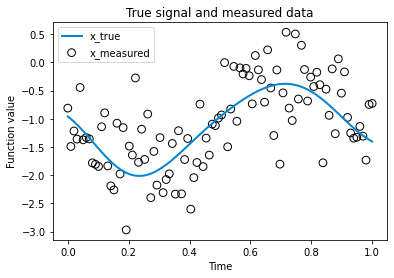

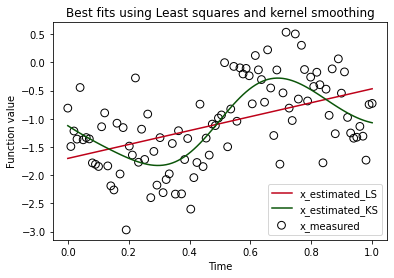

In [10]:

# 5.1 Figure showing the true underlying signal and the data passed to the algorithm
plt.figure(1)
plt.scatter(time,x_measured,s=60, facecolors='none', edgecolors='k')
plt.plot(time,x_true,color='xkcd:cerulean',linewidth=2)
plt.legend(['x_true','x_measured'])
plt.xlabel('Time')
plt.ylabel('Function value')
plt.title('True signal and measured data')

# 5.2 Figure showing the data and the best fits using Least squares and kernel smoothing
plt.figure(2)
plt.scatter(time,x_measured,s=60, facecolors='none', edgecolors='k')
plt.plot(time,x_estimated_LS,color='xkcd:scarlet')
plt.plot(time,x_estimated_KS,color='xkcd:forest')
plt.legend(['x_estimated_LS','x_estimated_KS','x_measured'])
plt.xlabel('Time')
plt.ylabel('Function value')
plt.title('Best fits using Least squares and kernel smoothing')

